# Results Visualizations
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results_latest = load_laaos_files()

In [ ]:
results_other = load_laaos_files("./results/random_bald_bbald_ical_rbald_tombald")

In [ ]:
results = {**results_latest, **results_other}

In [ ]:
get_any(results)

_Result(timestamp=1610133857, cmdline=['/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', '--id', '37'], commit='bfc8fa7e76c57cb5eb1138e8374a38f46ce0e7c8', github_url='bfc8fa7e76c57cb5eb1138e8374a38f46ce0e7c8', experiment='/auto/users/andsch/github/active_learning_redux/batchbald_redux/experiment.py', job_id=37, worker_id=37, num_workers=60, config=_config(seed=320, acquisition_size=5, max_training_set=300, num_pool_samples=20, num_eval_samples=4, num_training_samples=1, num_patience_epochs=3, max_training_epochs=10, validation_set_size=4096, initial_set_size=20, samples_per_epoch=24576, repeated_mnist_repetitions=2, add_dataset_noise=True, acquisition_function='AcquisitionFunction.temperedbald', save_bald_scores=False, temperature=15), log=_log(), initial_training_set_indices=[38043, 40091, 17418, 2094, 39879, 3133, 5011, 40683, 54379, 24287, 9849, 59305, 39508, 39356, 8758, 52579, 13655, 7636, 21562, 41329], active_learning_steps=[_ActiveLearningStepsIte

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(399, 399)

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    acquisition_size = result.config.acquisition_size
    seed = result.config.seed

    acquisition_function = result.config.acquisition_function[len("AcquisitionFunction.") :]
    temperature = result.config.temperature if hasattr(result.config, "temperature") else 0

    if temperature != 0:
        acquisition_function = f"{acquisition_function}@{temperature}K"

    if acquisition_function == "random":
        acquisition_sizes = [10, 5, 50, 20]
    else:
        acquisition_sizes = [acquisition_size]

    for acquisition_size in acquisition_sizes:
        initial_set_size = len(result.initial_training_set_indices)

        if (
            initial_set_size
            + sum(1 if hasattr(step, "evalution_metrics") else 0 for step in result.active_learning_steps)
            * result.config.acquisition_size
            < 250
        ):
            print(len(result.active_learning_steps), file)
            continue

        for i, step in enumerate(result.active_learning_steps):
            if not hasattr(step, "evalution_metrics"):
                break
            training_set_size = initial_set_size + i * result.config.acquisition_size
            accuracy = step.evalution_metrics.accuracy

            experiment_data.append(
                dict(
                    acquisition_function=acquisition_function,
                    acquisition_size=acquisition_size,
                    training_set_size=training_set_size,
                    accuracy=accuracy,
                    seed=seed,
                )
            )

1 /experiment_job_87_2021-01-08-230750.py
1 /experiment_job_63_2021-01-08-225022.py
1 /experiment_job_99_2021-01-08-231731.py
1 /experiment_job_78_2021-01-08-225905.py
1 /experiment_job_51_2021-01-08-224206.py
1 /experiment_job_48_2021-01-08-224107.py
1 /experiment_job_57_2021-01-08-224705.py
1 /experiment_job_60_2021-01-08-224833.py
1 /experiment_job_81_2021-01-08-230228.py
1 /experiment_job_90_2021-01-08-231031.py
1 /experiment_job_72_2021-01-08-225545.py
1 /experiment_job_45_2021-01-08-223951.py
1 /experiment_job_75_2021-01-08-225735.py
1 /experiment_job_66_2021-01-08-225059.py
1 /experiment_job_42_2021-01-08-223816.py
1 /experiment_job_84_2021-01-08-230435.py
1 /experiment_job_93_2021-01-08-231152.py
1 /experiment_job_54_2021-01-08-224400.py
1 /experiment_job_69_2021-01-08-225347.py
1 /experiment_job_96_2021-01-08-231300.py
1 /experiment_job_17_2021-01-04-135518.py
1 /experiment_job_6_2021-01-04-135400.py
1 /experiment_job_12_2021-01-04-135554.py
1 /experiment_job_16_2021-01-04-135

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,acquisition_function,acquisition_size,training_set_size,accuracy,seed
0,temperedbald@15K,5,20,0.6247,320
1,temperedbald@15K,5,25,0.6535,320
2,temperedbald@15K,5,30,0.6945,320
3,temperedbald@15K,5,35,0.7434,320
4,temperedbald@15K,5,40,0.7360,320
...,...,...,...,...,...
26345,random,20,280,0.9153,220
26346,random,20,285,0.9233,220
26347,random,20,290,0.9199,220
26348,random,20,295,0.9305,220


In [ ]:
df.acquisition_size.unique()

array([ 5, 50, 10, 20])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 20").groupby(["acquisition_size"])["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

acquisition_size  acquisition_function
5                 random                  80
                  thompsonbald            12
                  randombald              11
                  batchbald                8
                  bald                     7
                  batchbaldical            5
                  temperedbald@10K         5
                  temperedbald@13K         5
                  temperedbald@15K         5
                  temperedbald@18K         5
                  temperedbaldical@10K     5
                  temperedbaldical@8K      5
                  temperedbald@8K          4
10                random                  80
                  bald                    12
                  randombald              10
                  batchbald                9
                  thompsonbald             8
                  batchbaldical            5
                  temperedbald@10K         5
                  temperedbald@13K         5
                

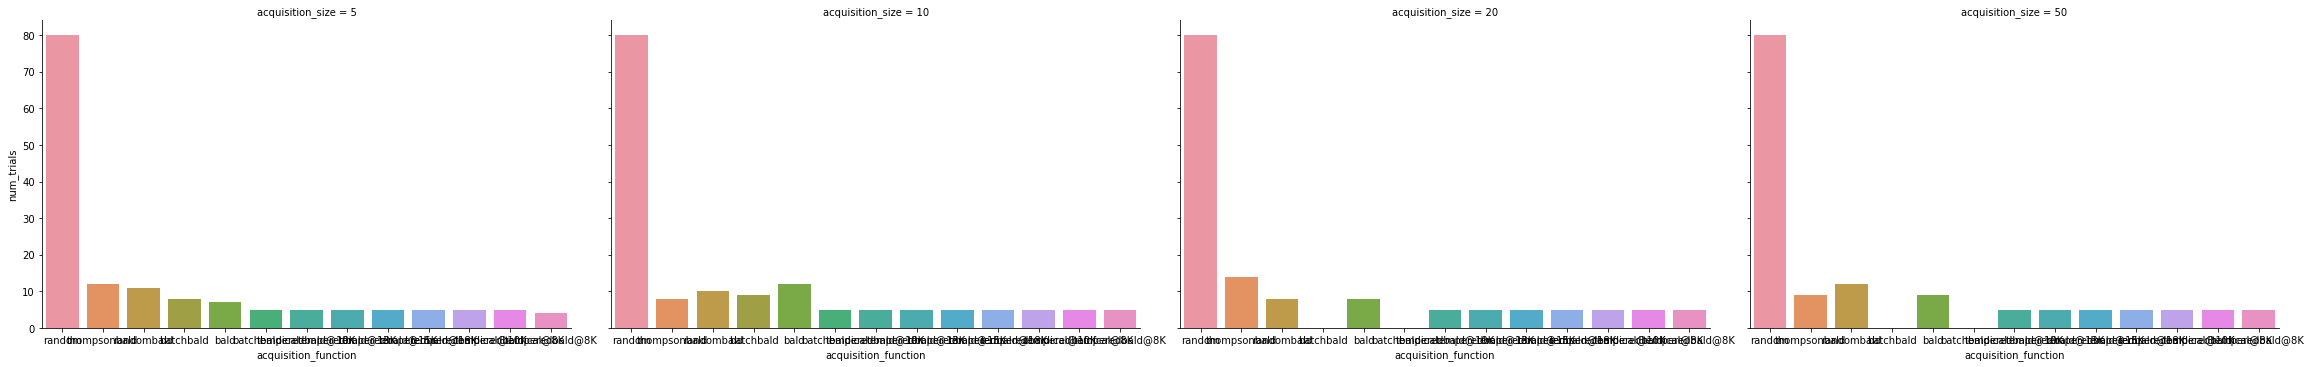

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

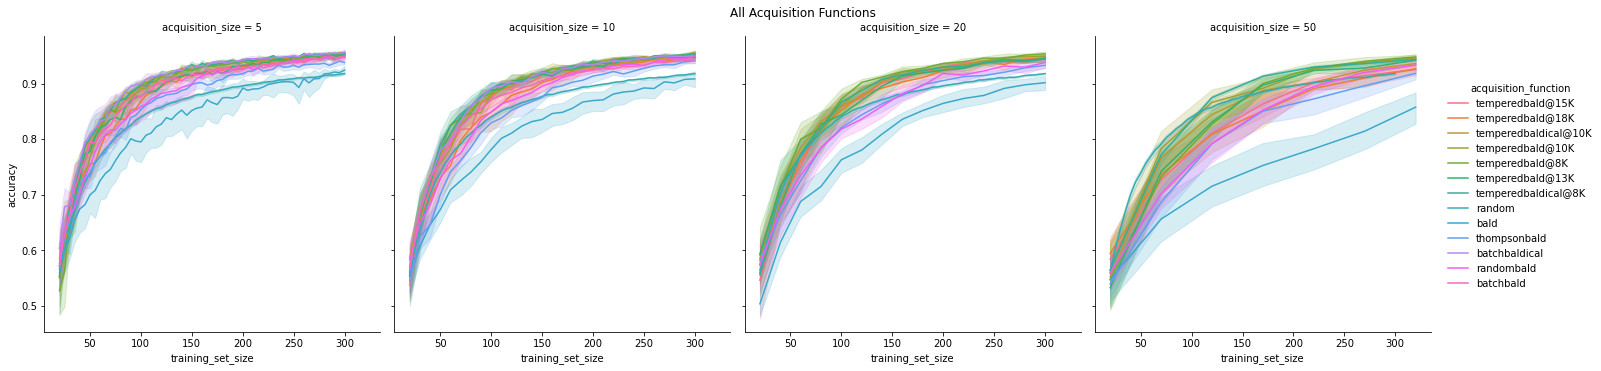

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
)

grd.fig.suptitle("All Acquisition Functions")
grd.fig.subplots_adjust(top=0.9)
grd.fig.patch.set_alpha(1)

In [ ]:
df.acquisition_function.unique()

array(['BALD@15K', 'BALD@18K', 'BALD@13K', 'random', 'bald',
       'thompsonbald', 'batchbaldical', 'randombald', 'batchbald'],
      dtype=object)

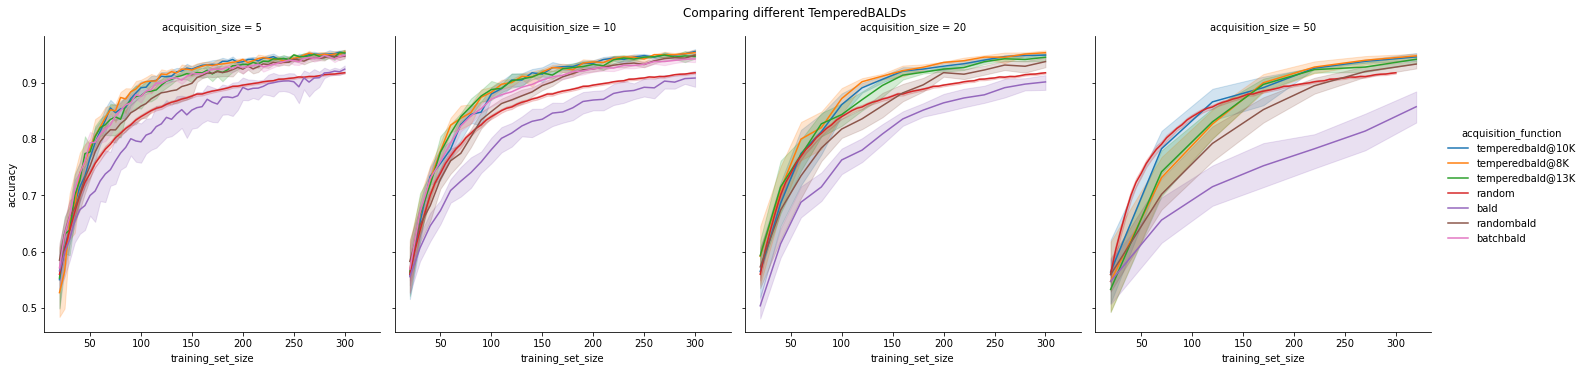

In [ ]:
# Comparing different TemperedBALDs

grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df[
        df["acquisition_function"].isin(
            [
                "batchbald",
                "temperedbald@8K",
                "temperedbald@10K",
                #"temperedbald@15K",
                #"temperedbald@18K",
                "temperedbald@13K",
                "randombald",
                "bald",
                "random",
            ]
        )
    ],
    kind="line",
    height=5,
)

grd.fig.suptitle("Comparing different TemperedBALDs")
grd.fig.subplots_adjust(top=0.9)
grd.fig.patch.set_alpha(1)

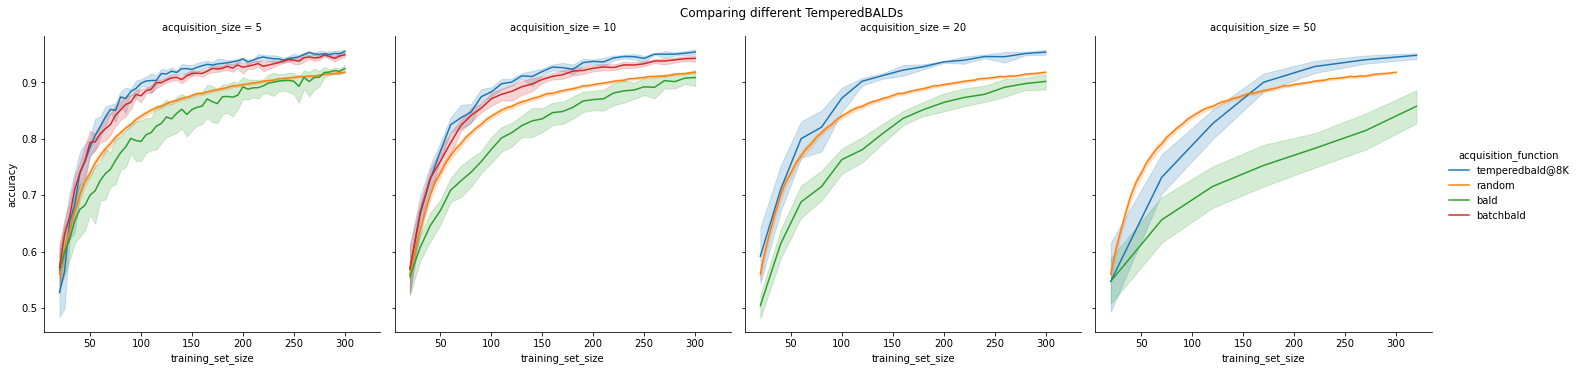

In [ ]:
# Comparing only different TemperedBALDs

grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df[
        df["acquisition_function"].isin(
            [
                "temperedbald@8K",
                "batchbald",
                "bald",
                "random",
            ]
        )
    ],
    kind="line",
    height=5,
)


grd.fig.suptitle("Comparing different TemperedBALDs")
grd.fig.subplots_adjust(top=0.9)
grd.fig.patch.set_alpha(1)

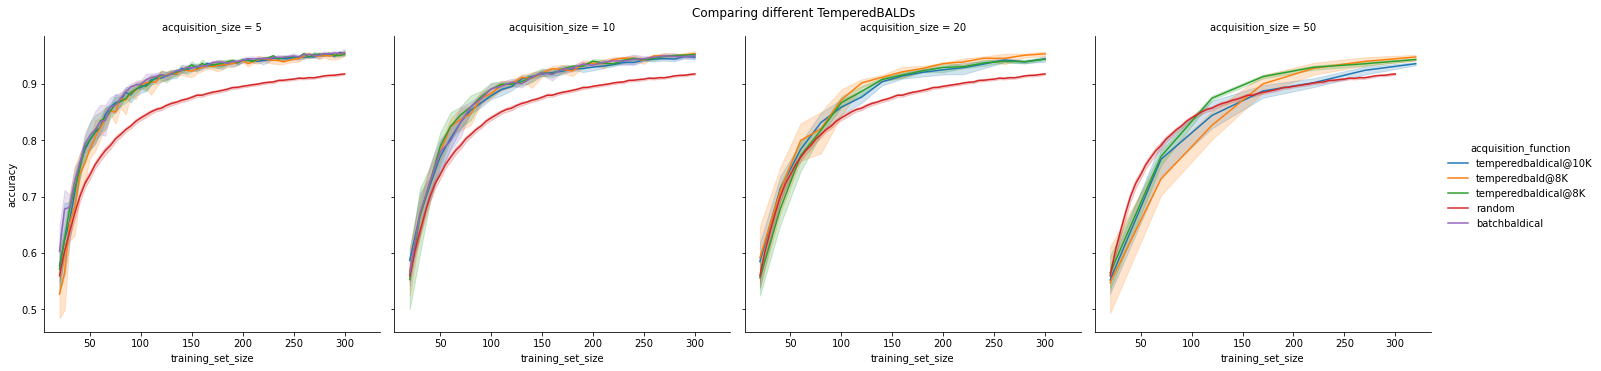

In [ ]:
# Comparing only different TemperedBALDs

grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df[
        df["acquisition_function"].isin(
            [
                "temperedbald@8K",
                "temperedbaldical@8K",
                "temperedbaldical@10K",
                "batchbaldical",
                "random"
            ]
        )
    ],
    kind="line",
    height=5,
)


grd.fig.suptitle("Comparing different TemperedBALDs")
grd.fig.subplots_adjust(top=0.9)
grd.fig.patch.set_alpha(1)

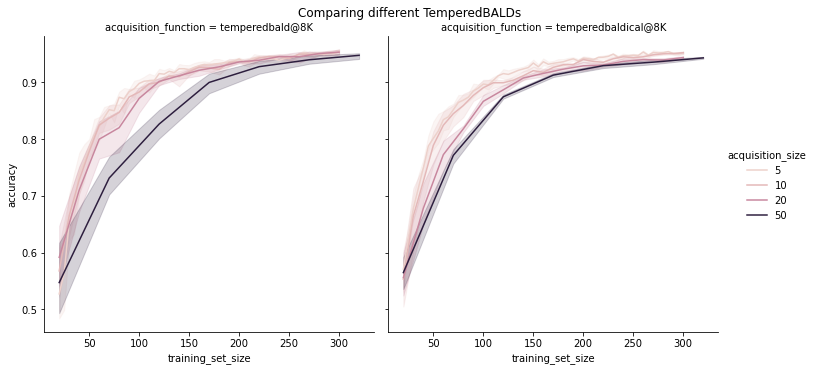

In [ ]:
# Comparing only different TemperedBALDs

grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    hue="acquisition_size",
    col="acquisition_function",
    data=df[
        df["acquisition_function"].isin(
            [
                "temperedbaldical@8K",
                "temperedbald@8K",
            ]
        )
    ],
    kind="line",
    height=5,
)


grd.fig.suptitle("Comparing different TemperedBALDs")
grd.fig.subplots_adjust(top=0.9)
grd.fig.patch.set_alpha(1)

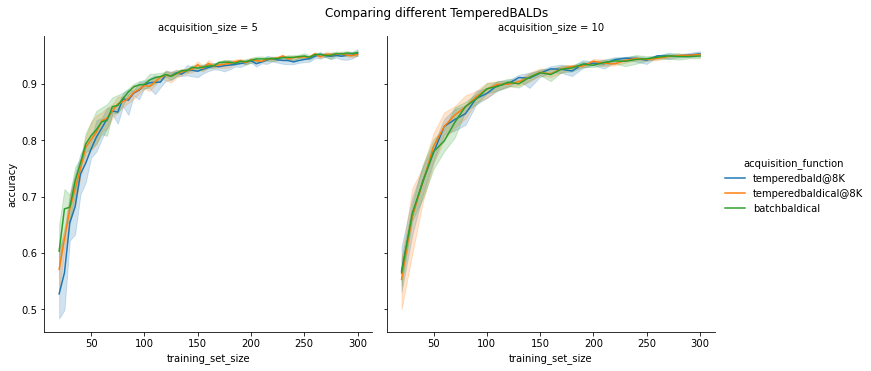

In [ ]:
# Comparing only different TemperedBALDs

grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    col="acquisition_size",
    hue="acquisition_function",
    data=df[
        df["acquisition_function"].isin(
            [
                "temperedbaldical@8K",
                "temperedbald@8K",
                "batchbaldical",
            ]
        ) & (df["acquisition_size"] <= 10)
    ],
    kind="line",
    height=5,
)


grd.fig.suptitle("Comparing different TemperedBALDs")
grd.fig.subplots_adjust(top=0.9)
grd.fig.patch.set_alpha(1)

In [ ]:
(df["acquisition_function"].isin(
            [
                "temperedbaldical@8K",
                "batchbaldical",
            ]
        ) & df["acquisition_size"] <= 10).sum()

970

In [ ]:
df2 = df[df.accuracy >= 0.89].groupby(["seed", "acquisition_size", "acquisition_function"]).first()

In [ ]:
df3 = df2.groupby(["acquisition_size", "acquisition_function"]).training_set_size.quantile([0.25, 0.5, 0.75])

In [ ]:
print(df3.unstack())

                                         0.25   0.50    0.75
acquisition_size acquisition_function                       
5                bald                  160.00  165.0  192.50
                 batchbald             107.50  112.5  115.00
                 batchbaldical          90.00   90.0   90.00
                 random                153.75  175.0  190.00
                 randombald            110.00  115.0  122.50
                 temperedbald@10K       95.00  105.0  110.00
                 temperedbald@13K       95.00  100.0  125.00
                 temperedbald@15K       90.00  115.0  120.00
                 temperedbald@18K      105.00  120.0  120.00
                 temperedbald@8K        88.75   92.5   96.25
                 temperedbaldical@10K   85.00   95.0  100.00
                 temperedbaldical@8K    95.00  100.0  105.00
                 thompsonbald          113.75  127.5  141.25
10               bald                  192.50  220.0  227.50
                 batchba

In [ ]:
xx = df[df.accuracy >= 0.90]
xx[xx.acquisition_function == "temperedbaldical@8K"]

,acquisition_function,acquisition_size,training_set_size,accuracy,seed
384,temperedbaldical@8K,50,170,0.9168,441
385,temperedbaldical@8K,50,220,0.9338,441
386,temperedbaldical@8K,50,270,0.9433,441
387,temperedbaldical@8K,50,320,0.9441,441
549,temperedbaldical@8K,50,170,0.9168,415
...,...,...,...,...,...
3689,temperedbaldical@8K,5,280,0.9541,380
3690,temperedbaldical@8K,5,285,0.9550,380
3691,temperedbaldical@8K,5,290,0.9539,380
3692,temperedbaldical@8K,5,295,0.9509,380
